# Fake News Detection com FakeBERT (BERT + CNN)

In [14]:
import pandas as pd
from sklearn.utils import shuffle
import re

# Carregar os datasets
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

# Adicionar rótulo: 0 = fake, 1 = true
df_fake['label'] = 0
df_true['label'] = 1

def limpar_prefixo_agencia(texto):
    return re.sub(r"^(.*?\(Reuters\)[\s\-–]*)", "", texto)

df_true['text'] = df_true['text'].apply(limpar_prefixo_agencia)

# Juntar os dados
df = pd.concat([df_fake, df_true], ignore_index=True)
df = shuffle(df).reset_index(drop=True)

# Remover textos duplicados antes da divisão
df = df.drop_duplicates(subset='text').reset_index(drop=True)

# Verificar estrutura
df[['title', 'text', 'label']].head()


,title,text,label
0,(Video)White House Says Obama’s Strategy Again...,Did someone not tell this goofball that Ramadi...,0
1,Trump team memo on climate change alarms Energ...,President-elect Donald Trump’s Energy Departme...,1
2,U.S. Embassy move can be done in 'two minutes'...,Israel s mayor of Jerusalem Nir Barkat said on...,1
3,Iran's Guards say missile programme will accel...,Iran s elite Islamic Revolutionary Guards (IRG...,1
4,WATCH: HARVARD STUDENTS Caught On Tape Saying ...,Is there a worse crime than being a white male...,0


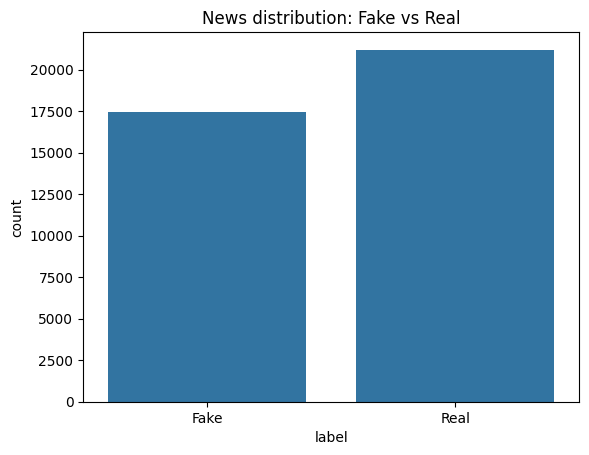

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribuição das classes
sns.countplot(x='label', data=df)
plt.title("News distribution: Fake vs Real")
plt.xticks([0,1], ['Fake', 'Real'])
plt.show()


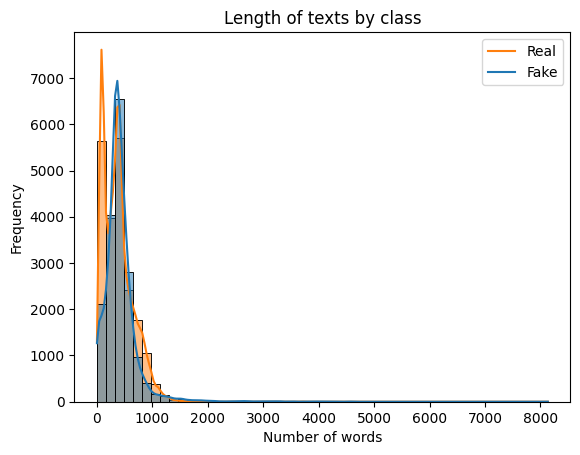

In [16]:

# 2. Comprimento dos textos
df['len_texto'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='len_texto', hue='label', bins=50, kde=True)
plt.title("Length of texts by class")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.legend(labels=["Real", "Fake"])
plt.show()


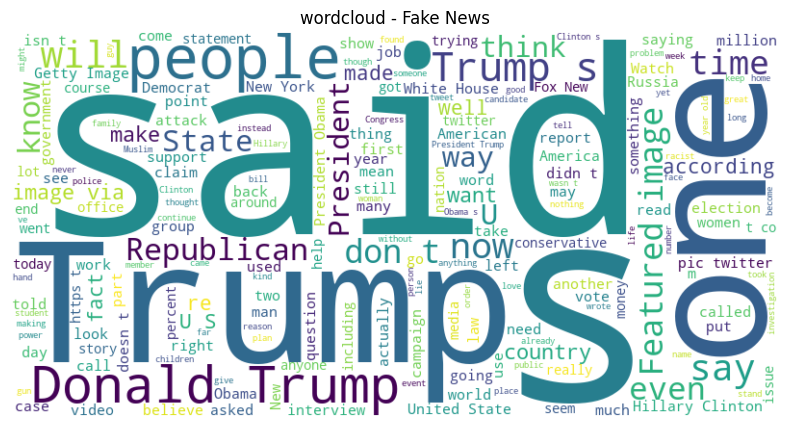

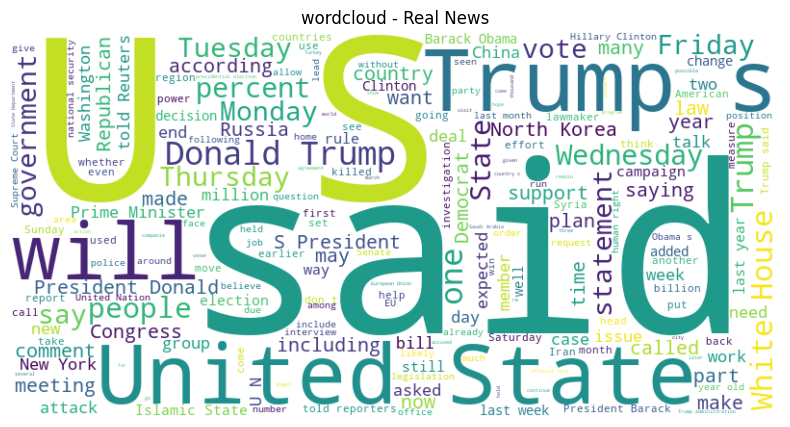

In [17]:
from wordcloud import WordCloud

# 3. Nuvem de palavras
for label in [0, 1]:
    text_all = " ".join(df[df['label'] == label]['text'].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_all)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("wordcloud - " + ("Fake News" if label == 0 else "Real News"))
    plt.show()

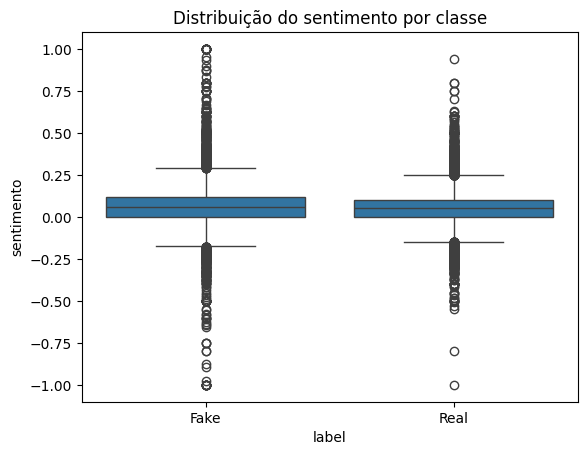

In [18]:
from textblob import TextBlob

# 4. Análise de sentimento 
def analisar_sentimento(texto):
    return TextBlob(str(texto)).sentiment.polarity

df['sentimento'] = df['text'].apply(analisar_sentimento)

sns.boxplot(x='label', y='sentimento', data=df)
plt.title("Distribuição do sentimento por classe")
plt.xticks([0,1], ['Fake', 'Real'])
plt.show()


In [19]:
# Dividir em treino, validação e teste
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [20]:
# Tokenização com BERT
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

c:\Users\artur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import torch
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Criar datasets
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

In [22]:
import torch.nn as nn
from transformers import BertModel

class FakeBERT_CNN(nn.Module):
    def __init__(self):
        super(FakeBERT_CNN, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        # BERT embeddings
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B, T, 768)
        x = bert_out.permute(0, 2, 1)  # (B, 768, T)
        x = torch.relu(self.conv1(x))  # (B, 128, T)
        x = self.pool(x).squeeze(2)    # (B, 128)
        x = self.dropout(x)
        logits = self.fc(x).squeeze(1)  # (B)
        return logits

In [23]:
from torch.utils.data import DataLoader

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeBERT_CNN().to(device)

# Otimizador e função de custo
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()


In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Treino"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [25]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validação"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    preds_bin = [1 if p >= 0.5 else 0 for p in preds]
    acc = accuracy_score(true_labels, preds_bin)
    f1 = f1_score(true_labels, preds_bin)
    roc = roc_auc_score(true_labels, preds)

    return total_loss / len(loader), acc, f1, roc

In [26]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"\n🌟 Época {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, acc, f1, roc = evaluate(model, val_loader, criterion, device)

    print(f"\n📈 Val Loss: {val_loss:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC AUC: {roc:.4f}")



🌟 Época 1/3


Validação: 100%|██████████| 242/242 [00:12<00:00, 19.20it/s]



📈 Val Loss: 0.0139 | Accuracy: 0.9956 | F1: 0.9960 | ROC AUC: 0.9999

🌟 Época 2/3


Validação: 100%|██████████| 242/242 [00:15<00:00, 16.04it/s]



📈 Val Loss: 0.0325 | Accuracy: 0.9899 | F1: 0.9909 | ROC AUC: 0.9999

🌟 Época 3/3


Validação: 100%|██████████| 242/242 [00:13<00:00, 17.98it/s]


📈 Val Loss: 0.0105 | Accuracy: 0.9972 | F1: 0.9974 | ROC AUC: 0.9999


In [27]:
test_loader = DataLoader(test_dataset, batch_size=16)

test_loss, test_acc, test_f1, test_roc = evaluate(model, test_loader, criterion, device)

print(f"🧪 Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | F1: {test_f1:.4f} | ROC AUC: {test_roc:.4f}")

Validação: 100%|██████████| 242/242 [00:13<00:00, 17.90it/s]

🧪 Test Loss: 0.0140 | Accuracy: 0.9948 | F1: 0.9953 | ROC AUC: 0.9999
